# **Predicting Hospital Admission Duration**


# **Summary**
This notebook develops a robust machine learning model to predict hospital length of stay, supporting improved healthcare management and resource allocation. Beginning with a large healthcare dataset, the project performs thorough exploratory data analysis to uncover key relationships among patient demographics, medical conditions, and hospital services. A comprehensive preprocessing pipeline cleans the data, handles categorical features, and removes irrelevant variables. Multiple regression models are trained and evaluated using Mean Squared Error (MSE) and R-squared metrics. Additionally, Random Forest feature importance is analyzed to identify the most influential factors affecting hospital stay duration.

## **Prerequisites**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read the healthcare dataset file
data = pd.read_csv("healthcare_data.csv")

In [ ]:
# Copying data to another variable to avoid any changes to original data
same_data = data.copy()

## **Data Overview**

In [ ]:
# View the first 5 rows of the dataset
data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [ ]:
# Understand the shape of the data
data.shape

(500000, 15)

In [ ]:
# Checking the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  500000 non-null  int64  
 1   Department                         500000 non-null  object 
 2   Ward_Facility_Code                 500000 non-null  object 
 3   doctor_name                        500000 non-null  object 
 4   staff_available                    500000 non-null  int64  
 5   patientid                          500000 non-null  int64  
 6   Age                                500000 non-null  object 
 7   gender                             500000 non-null  object 
 8   Type of Admission                  500000 non-null  object 
 9   Severity of Illness                500000 non-null  object 
 10  health_conditions                  500000 non-null  object 
 11  Visitors with Patient              5000

**Observations:**

-  Available Extra Rooms in Hospital, staff_available, patientid, Visitors with Patient, Admission_Deposit, and Stay (in days) are of numeric data type and the rest of the columns are of object data type.
- There are no null values.
- The column patientid is an identifier for patients in the data. This column will not help with our analysis so we can drop it.

In [ ]:
# Patient id and the number of times they have been admitted to the hospital
data['patientid'].value_counts()

126719    21
125695    21
44572     21
126623    21
125625    19
          ..
37634      1
91436      1
118936     1
52366      1
105506     1
Name: patientid, Length: 126399, dtype: int64

In [ ]:
# Dropping patientid from the data as it is an identifier and will not add value to the analysis
data=data.drop(columns=["patientid"])

In [ ]:
# Checking for duplicate values in the data
data.duplicated().sum()

0

In [ ]:
# Checking the descriptive statistics of the columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Available Extra Rooms in Hospital,500000.0,3.638800,2.698124,0.000000,2.000000,3.000000,4.000000,24.00000
staff_available,500000.0,5.020470,3.158103,0.000000,2.000000,5.000000,8.000000,10.00000
Visitors with Patient,500000.0,3.549414,2.241054,0.000000,2.000000,3.000000,4.000000,32.00000
Admission_Deposit,500000.0,4722.315734,1047.324220,1654.005148,4071.714532,4627.003792,5091.612717,10104.72639
Stay (in days),500000.0,12.381062,7.913174,3.000000,8.000000,9.000000,11.000000,51.00000


**Observations:**

* There are around 3 rooms available in the hospital on average** and there are times when the hospital is full and there are no rooms available (minimum value is 0). The maximum number of rooms available in the hospital is 24.
* On average, there are around 5 staff personnel available to treat the new patients but it can also be zero at times. The maximum number of staff available in the hospital is 10.
* On average, around 3 visitors accompany the patient. Some patients come on their own (minimum value is zero) and a few cases have 32 visitors. It will be interesting to see if there is any relationship between the number of visitors and the severity of the patient.
* The average admission deposit lies around 4,722 dollars and a minimum of 1,654 dollars is paid on every admission.
* Patient's stay ranges from 3 to 51 days. There might be outliers in this variable. The median length of stay is 9 days.

In [ ]:
# List of important categorical variables
cat_col = ["Department", "Type of Admission", 'Severity of Illness', 'gender', 'Insurance', 'health_conditions', 'doctor_name', "Ward_Facility_Code", "Age"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(data[column].value_counts(1))
    print("-" * 50)

gynecology            0.686956
radiotherapy          0.168630
anesthesia            0.088358
TB & Chest disease    0.045780
surgery               0.010276
Name: Department, dtype: float64
--------------------------------------------------
Trauma       0.621072
Emergency    0.271568
Urgent       0.107360
Name: Type of Admission, dtype: float64
--------------------------------------------------
Moderate    0.560394
Minor       0.263074
Extreme     0.176532
Name: Severity of Illness, dtype: float64
--------------------------------------------------
Female    0.74162
Male      0.20696
Other     0.05142
Name: gender, dtype: float64
--------------------------------------------------
Yes    0.78592
No     0.21408
Name: Insurance, dtype: float64
--------------------------------------------------
None                   0.303776
Other                  0.188822
High Blood Pressure    0.158804
Diabetes               0.147288
Asthama                0.131028
Heart disease          0.070282
Name: hea

**Observations:**

- The majority of patients (~82%) admit to the hospital with moderate and minor illness, which is understandable as extreme illness is less frequent than moderate and minor illness.
- Gynecology department gets the most number of patients (~68%) in the hospital, whereas patients in Surgery department are very few (~1%).
- Ward A and C accommodate the least number of patients (~12%). These might be wards reserved for patient with extreme illness and patients who need surgery. It would be interesting to see if patients from these wards also stay for longer duration.
- The majority of patients belong to the age group of 21-50 (~75%), and the majority of patients are women (~74%). The most number of patients in the gynecology department of the hospital can justify this.
- Most of the patients admitted to the hospital are the cases of trauma (~62%).
- After 'Other' category, High Blood Pressure and Diabetes are the most common health conditions.

## **Exploratory Data Analysis (EDA)**

In [ ]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      
        sharex = True, 
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )                   
    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )                   
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )                  
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )                   
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )                   

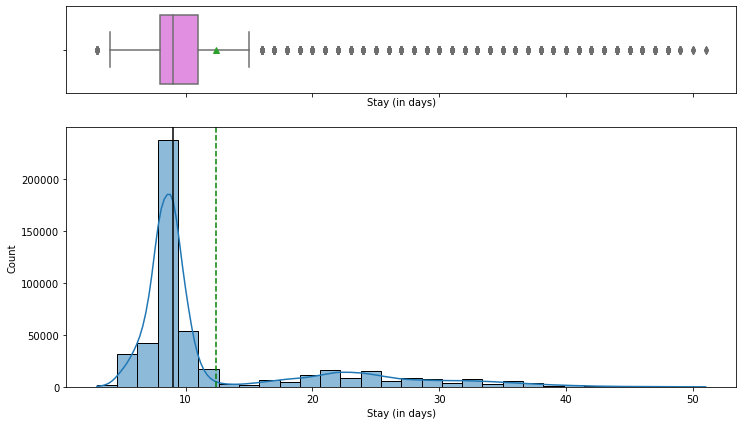

In [ ]:
# Length of stay
histogram_boxplot(data, "Stay (in days)", kde = True, bins = 30)

**Observations:**

- Fewer patients are staying more than 10 days in the hospital and very few stay for more than 40 days. This might be because the majority of patients are admitted for moderate or minor illnesses.
- The peak of the distribution shows that most of the patients stay for 8-9 days in the hospital.

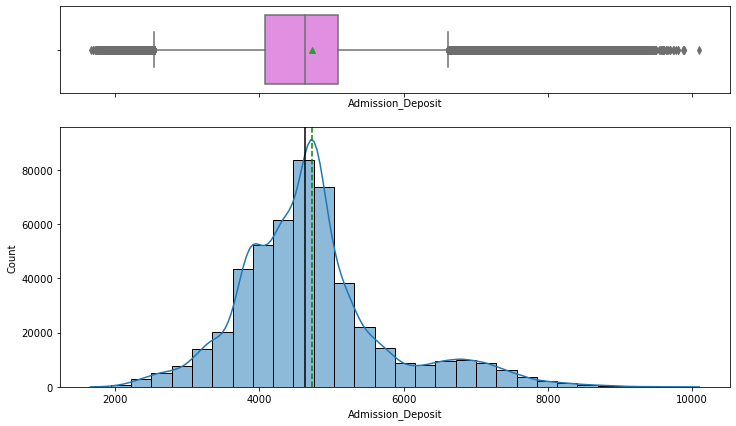

In [ ]:
# Admission Deposit
histogram_boxplot(data, "Admission_Deposit", kde = True, bins = 30)

**Observation:**

- The distribution of admission fees is close to normal with outliers on both sides. Few patients are paying a high amount of admission fees and few patients are paying a low amount of admission fees.

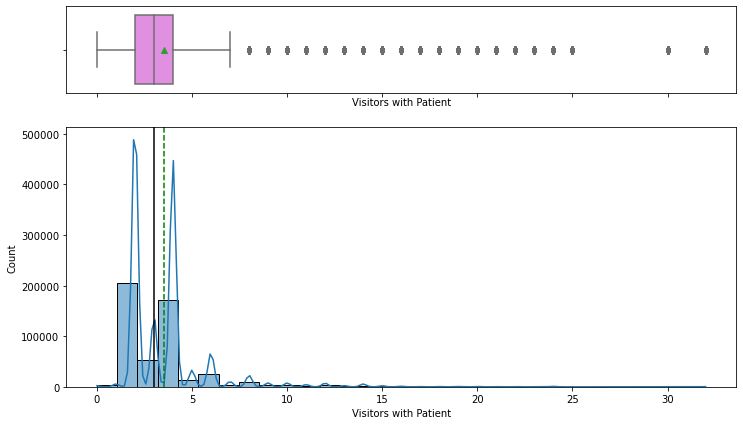

In [ ]:
# Visitors with Patients
histogram_boxplot(data, "Visitors with Patient", kde = True, bins = 30)

**Observations:**

- The distribution of the number of visitors with the patient is highly skewed towards the right.
- 2 and 4 are the most common number of visitors with patients.

<AxesSubplot:>

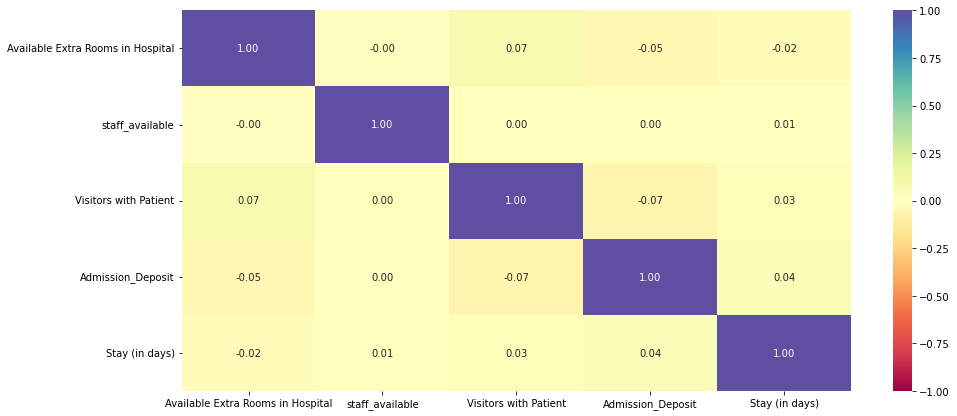

In [ ]:
# Finding the correlation between various columns of the dataset
plt.figure(figsize = (15,7))
sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")

**Observations:**
- The continuous variables show no correlation with the target variable (Stay (in days)), which indicates that the categorical variables might be more important for the prediction.

In [ ]:
def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins = True).sort_values(
        by = sorter, ascending = False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize = "index").sort_values(
        by = sorter, ascending = False
    )
    tab.plot(kind = "bar", stacked = True, figsize = (count + 1, 5))
    plt.legend(
        loc = "lower left",
        frameon = False,
    )
    plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
    plt.show()

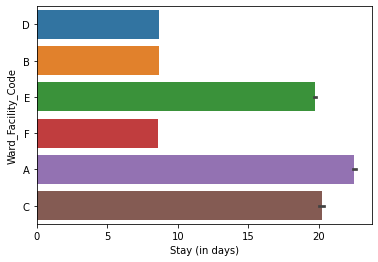

In [ ]:
sns.barplot(y = 'Ward_Facility_Code', x = 'Stay (in days)', data = data)
plt.show()

**Observation:**

- Wards A and C has the patients staying for the longest duration, which implies these wards might be for patients with serious illnesses.

Department          TB & Chest disease  anesthesia  gynecology  radiotherapy  \
Ward_Facility_Code                                                             
A                                 4709       15611           0         21093   
All                              22890       44179      343478         84315   
B                                    0           0      103885             0   
C                                 1319        4199           0          9079   
D                                    0           0      119055             0   
E                                16862       24369           0         54143   
F                                    0           0      120538             0   

Department          surgery     All  
Ward_Facility_Code                   
A                      5138   46551  
All                    5138  500000  
B                         0  103885  
C                         0   14597  
D                         0  119055  
E            

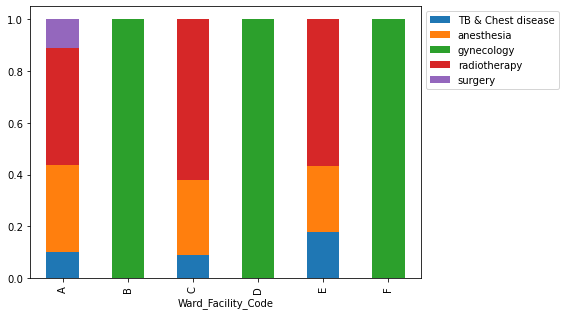

In [ ]:
stacked_barplot(data, "Ward_Facility_Code", "Department")

**Observations:**

- Ward Facility B, D, and F are dedicated only to the gynecology department.
- Wards A, C, and E have patients with all other diseases, and patients undergoing surgery are admitted to ward A only.

Severity of Illness  Extreme   Minor  Moderate     All
Ward_Facility_Code                                    
All                    88266  131537    280197  500000
D                      29549   27220     62286  119055
B                      24222   23579     56084  103885
A                      13662    7877     25012   46551
E                      11488   22254     61632   95374
F                       5842   47594     67102  120538
C                       3503    3013      8081   14597
------------------------------------------------------------------------------------------------------------------------


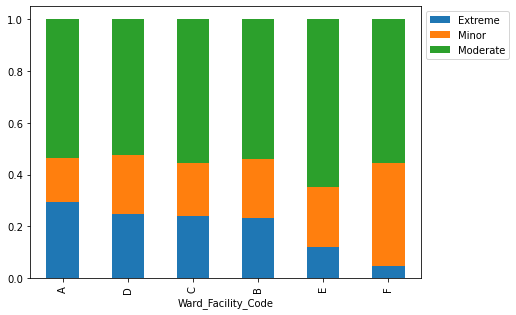

In [ ]:
stacked_barplot(data, "Ward_Facility_Code", "Severity of Illness")

**Observations:**

- Ward A has the highest number of extreme cases. We observed earlier that ward A has the longest length of stay in the hospital as well. It might require more staff and resources as compared to other wards.
- Ward F has the highest number of minor cases and Ward E has the highest number of moderate cases.

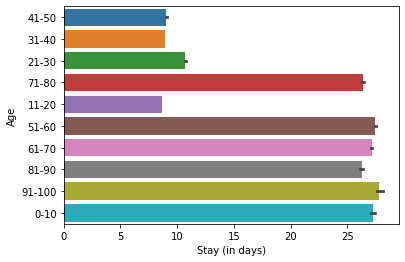

In [ ]:
sns.barplot(y = 'Age', x = 'Stay (in days)', data = data)
plt.show()

**Observation:**

- Patients aged between 1-10 and 51-100 tend to stay the most number of days in the hospital. This might be because the majority of the patients between the 21-50 age group get admitted to the gynecology department and patients in age groups 1-10 and 5-100 might get admitted due to some serious illness.

In [ ]:
data.groupby(['doctor_name'])['Department'].agg(Department_Name='unique',Patients_Treated='count')

,Department_Name,Patients_Treated
doctor_name,,
Dr Isaac,[surgery],3359
Dr John,"[TB & Chest disease, anesthesia, radiotherapy]",51263
Dr Mark,"[anesthesia, TB & Chest disease]",44410
Dr Nathan,[gynecology],70777
Dr Olivia,[gynecology],98352
Dr Sam,[radiotherapy],55711
Dr Sarah,[gynecology],99596
Dr Simon,[surgery],1779
Dr Sophia,[gynecology],74753


**Observations:**

- The hospital employs a total of 9 doctors. Four of the doctors work in the department of gynecology, which sees the most patients.
- The majority of patients that attended the hospital were treated by Dr. Sarah and Olivia.
- Two doctors are working in the surgical department (Dr. Isaac and Dr. Simon), while Dr. Sam works in the radiotherapy department.
- The only two doctors who work in several departments are Dr. John and Dr. Mark.

## **Data Preparation**

In [ ]:
# Creating dummy variables for the categorical columns
data = pd.get_dummies(
    data,
    columns = data.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)

In [ ]:
# Separating independent variables and the target variable
x = data.drop('Stay (in days)',axis=1)
y = data['Stay (in days)']

In [ ]:
# Splitting the dataset into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

In [ ]:
# Checking the shape of the train and test data
print("Shape of Training set : ", x_train.shape)
print("Shape of test set : ", x_test.shape)

Shape of Training set :  (400000, 42)
Shape of test set :  (100000, 42)


In [ ]:
# Scaling the data
sc = StandardScaler()

X_scaled = sc.fit_transform(x_train)
x_train = pd.DataFrame(X_scaled, columns = x.columns)

x_test = sc.transform(x_test)

## **Model Building**

In [ ]:
# Adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# Compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):

    pred = model.predict(predictors)                  
    r2 = r2_score(target, pred)                       # To compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)    # To compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # To compute RMSE
    mae = mean_absolute_error(target, pred)           # To compute MAE
    mape = mape_score(target, pred)                   # To compute MAPE

    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

### **OLS**

In [ ]:
x_train1 = x_train.astype(float)
y_train1 = y_train.astype(float)

x_train1 = sm.add_constant(x_train1)
x_test1 = sm.add_constant(x_test)
olsmodel1 = sm.OLS(y_train1, x_train1).fit()

olsmodel1.summary()
print(olsmodel1.summary())

                            OLS Regression Results                            
Dep. Variable:         Stay (in days)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 5.796e+04
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        05:24:55   Log-Likelihood:            -1.0246e+06
No. Observations:              400000   AIC:                         2.049e+06
Df Residuals:                  399962   BIC:                         2.050e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

**Observations:**

- We can observe that `R-squared` for the model is `~0.84`.
- Not all the variables are statistically significant enough to predict the outcome variable.



In [ ]:
print("Performance on train data: ")
model_performance_regression(olsmodel1, x_train1, y_train)

Performance on train data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


In [ ]:
print("Performance on test data: ")
model_performance_regression(olsmodel1, x_test1, y_test)

Performance on test data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842962,19.676966


**Observations:**

- The Root Mean Squared Error of train and test data are very close, indicating that our model is not overfitting to the training data.
- Mean Absolute Error (MAE) indicates that the current model can predict LOS of patients within mean error of 2.15 days on the test data.
- Mean Absolute Percentage Error is ~19% on the test data, indicating that the average difference between the predicted value and the actual value is ~19%.

In [ ]:
# Checking for Multicollinearity

def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif

In [ ]:
print(checking_vif(x_train1))

                                  feature        VIF
0                                   const   0.000000
1       Available Extra Rooms in Hospital   1.023185
2                         staff_available   1.001928
3                   Visitors with Patient   1.029215
4                       Admission_Deposit   1.021085
5                   Department_anesthesia   2.737453
6                   Department_gynecology        inf
7                 Department_radiotherapy   7.650799
8                      Department_surgery        inf
9                    Ward_Facility_Code_B        inf
10                   Ward_Facility_Code_C   1.366865
11                   Ward_Facility_Code_D        inf
12                   Ward_Facility_Code_E   2.878866
13                   Ward_Facility_Code_F        inf
14                    doctor_name_Dr John        inf
15                    doctor_name_Dr Mark        inf
16                  doctor_name_Dr Nathan        inf
17                  doctor_name_Dr Olivia     

All the VIF<5, so there is no Multicollinearity.

From the above, it may be noted that the regression coefficients corresponding to staff_available, Visitors with Patient, and Insurance_Yes are not statistically significant at significance level α = 0.05. In other words, the regression coefficients corresponding to these three are not significantly different from 0 in the population.

Hence, we will eliminate these three features and create a new model.

In [ ]:
# Dropping variables
x_train2 = x_train1.drop(['Insurance_Yes','staff_available','Visitors with Patient'], axis = 1)
x_test2 = x_test1.drop(['Insurance_Yes','staff_available','Visitors with Patient'], axis = 1)

# Train the model
olsmodel2 = sm.OLS(y_train, x_train2).fit()

# Get the model summary
olsmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Stay (in days)   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 6.307e+04
Date:                Mon, 06 May 2024   Prob (F-statistic):               0.00
Time:                        05:26:17   Log-Likelihood:            -1.0246e+06
No. Observations:              400000   AIC:                         2.049e+06
Df Residuals:                  399965   BIC:                         2.050e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    19.8886      0.053    373.758      0.000      19.784      19.993
Available Extra Rooms in Hospital         0.0786      0.002     42.391      0.000       0.075       0.082
Admission_Deposit                     -3.842e-05   4.77e-06     -8.051      0.000   -4.78e-05   -2.91e-05
Department_anesthesia                     6.0822      0.029    210.152      0.000       6.025       6.139
Department_gynecology                     0.4628      0.019     24.518      0.000       0.426       0.500
Department_radiotherapy                  -4.6217      0.037   -126.175      0.000      -4.694      -4.550
Department_surgery                        9.6854      0.044    218.982      0.000       9.599       9.772
Ward_Facility_Code_B                      0.2569      0.011     23.599      0.000       0.236       0.278
Ward_Facility_Code_C                      0.4350      0.034     12.611      0.000       0.367       0.503
Ward_Facility_Code_D                      0.2032      0.010     19.495      0.000       0.183       0.224
Ward_Facility_Code_E                      0.3085      0.021     14.438      0.000       0.267       0.350
Ward_Facility_Code_F                      0.0027      0.011      0.248      0.804      -0.019       0.024
doctor_name_Dr John                       7.2624      0.031    236.018      0.000       7.202       7.323
doctor_name_Dr Mark                       1.1947      0.033     36.462      0.000       1.130       1.259
doctor_name_Dr Nathan                    -0.2125      0.015    -14.014      0.000      -0.242      -0.183
doctor_name_Dr Olivia                    -0.3592      0.015    -24.646      0.000      -0.388      -0.331
doctor_name_Dr Sam                        1.2833      0.038     33.914      0.000       1.209       1.358
doctor_name_Dr Sarah                      0.8184      0.016     50.617      0.000       0.787       0.850
doctor_name_Dr Simon                      6.1594      0.069     89.118      0.000       6.024       6.295
doctor_name_Dr Sophia                     0.2162      0.020     10.584      0.000       0.176       0.256
Age_11-20                               -12.7379      0.065   -194.593      0.000     -12.866     -12.610
Age_21-30                               -10.4831      0.062   -168.470      0.000     -10.605     -10.361
Age_31-40                               -13.4355      0.062   -216.959      0.000     -13.557     -13.314
Age_41-50                               -13.5114      0.062   -216.835      0.000     -13.634     -13.389
Age_51-60                                -0.3666      0.065     -5.652      0.000      -0.494      -0.239
Age_61-70                                -0.4217      0.064     -6.592      0.000      -0.547      -0.296
Age_71-80

In [ ]:
print("Performance on train data: ")
model_performance_regression(olsmodel2, x_train2, y_train)

Performance on train data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135098,2.146237,0.842812,0.842797,19.591701


In [ ]:
print("Performance on test data: ")
lin_reg_test = model_performance_regression(olsmodel2, x_test2, y_test)
lin_reg_test

Performance on test data: 


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144053,2.155762,0.843028,0.842967,19.676967


**Observation:**

* RMSE, MAE, and MAPE of train and test data are very close, indicating that the model is not overfitting and has generalized well over the unseen data.

### **Checking for assumptions**

In [ ]:
# Residuals
residual = olsmodel2.resid

In [ ]:
# Mean of residuals should be 0 and normality of error terms
residual.mean()

-1.5493283456180506e-12

- The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

<Axes: ylabel='Count'>

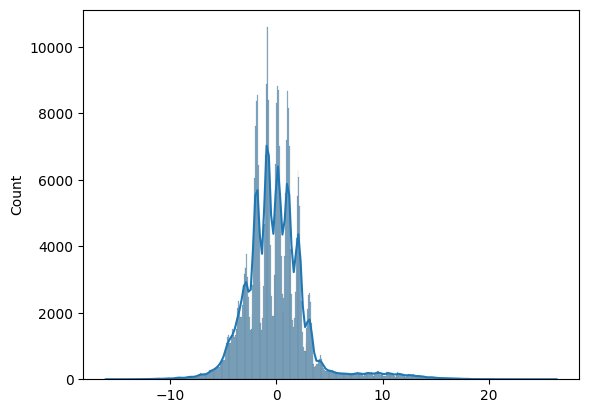

In [ ]:
# Plot histogram of residuals to test the normality
sns.histplot(residual, kde=True)

- The residuals have a close to normal distribution. The assumption of normality is satisfied.

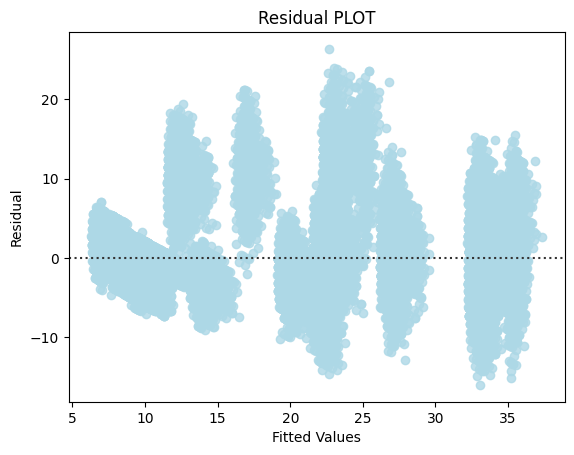

In [ ]:
# Linearity of Variables

# Predicted values
fitted = olsmodel2.fittedvalues

# Plotting Residuals VS Fitted Values
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

**Observation:**

- We can observe that there is no pattern in the residuals vs fitted values scatter plot, i.e., the linearity assumption is satisfied.

In [ ]:
# No Heteroscedasticity
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residual, x_train2)
lzip(name, test)

[('F statistic', 1.0039164146411328), ('p-value', 0.19107310271679429)]

**Observation:**

- As we can observe from the above test, the p-value is greater than 0.05. So, we fail to reject the null-hypothesis, i.e., residuals are homoscedastic.

All the assumptions for the linear regression model are satisfied. With our model's adjusted R-squared value of around 0.84, we can capture 84% of the variation in the data.

The p-values for the independent variables are less than 0.05 in our final model, indicating that they are statistically significant toward Length of Stay (in days) prediction.


In [ ]:
coef = olsmodel2.params
coef

const                                    19.888611
Available Extra Rooms in Hospital         0.078611
Admission_Deposit                        -0.000038
Department_anesthesia                     6.082191
Department_gynecology                     0.462834
Department_radiotherapy                  -4.621748
Department_surgery                        9.685354
Ward_Facility_Code_B                      0.256912
Ward_Facility_Code_C                      0.435021
Ward_Facility_Code_D                      0.203221
Ward_Facility_Code_E                      0.308490
Ward_Facility_Code_F                      0.002702
doctor_name_Dr John                       7.262411
doctor_name_Dr Mark                       1.194666
doctor_name_Dr Nathan                    -0.212506
doctor_name_Dr Olivia                    -0.359233
doctor_name_Dr Sam                        1.283345
doctor_name_Dr Sarah                      0.818361
doctor_name_Dr Simon                      6.159364
doctor_name_Dr Sophia          

In [ ]:
# The equation of the model
Equation = "Stay (in days)="
print(Equation, end='\t')
for i in range(len(coef)):
    print('(', coef[i], ') * ', coef.index[i], '+', end = ' ')

Stay (in days)=	( 19.888610855870557 ) *  const + ( 0.07861088283125785 ) *  Available Extra Rooms in Hospital + ( -3.8424599274500205e-05 ) *  Admission_Deposit + ( 6.082190541593325 ) *  Department_anesthesia + ( 0.46283441247923873 ) *  Department_gynecology + ( -4.621748096791961 ) *  Department_radiotherapy + ( 9.68535427036408 ) *  Department_surgery + ( 0.256912166907384 ) *  Ward_Facility_Code_B + ( 0.43502142725857085 ) *  Ward_Facility_Code_C + ( 0.20322070576091433 ) *  Ward_Facility_Code_D + ( 0.3084901213984342 ) *  Ward_Facility_Code_E + ( 0.0027015398109633674 ) *  Ward_Facility_Code_F + ( 7.262410614558021 ) *  doctor_name_Dr John + ( 1.1946664296565193 ) *  doctor_name_Dr Mark + ( -0.2125061391716403 ) *  doctor_name_Dr Nathan + ( -0.3592329256993671 ) *  doctor_name_Dr Olivia + ( 1.2833451288126763 ) *  doctor_name_Dr Sam + ( 0.8183606659514702 ) *  doctor_name_Dr Sarah + ( 6.15936433185227 ) *  doctor_name_Dr Simon + ( 0.21621281139881324 ) *  doctor_name_Dr Sophia +

#### **Interpreting the Regression Coefficients**

* The Stay (in days) decreases with an increase in Department_radiotherapy. 1 unit increase in the Department_radiotherapy leads to a decrease of Stay (in days) ~ 4.62 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant.

* The Stay (in days) increases with an increase in Department_anesthesia. 1 unit increase in Department_anesthesia leads to an increase of Stay (in days) ~ 6.08 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant. This is understandable, as anesthesia is used in severe cases which results in more days of stay.

* The Stay (in days) increases with an increase in Department_surgery. 1 unit increase in Department_surgery leads to an increase of Stay (in days) ~ 9.68 times the Stay (in days) than the Department_TB&Chest_Disease that serves as a reference variable when everything else is constant. This is understandable, as surgery is conducted in severe cases which results in more days of stay.

* The Stay (in days) increases with an increase in doctor_name_Dr Simon. 1 unit increase in doctor_name_Dr Simon leads to an increase of Stay (in days) ~ 6.14 times the Stay (in days) than the doctor_name_Dr Isaac that serves as a reference variable when everything else is constant. This is understandable, as surgery cases are handled by Dr. Simon.

Now we will train our linear regression models using final x_train and x_test.

### **Linear Regression**

In [ ]:
model = LinearRegression()
model.fit(x_train2, y_train)

LinearRegression()

In [ ]:
# Checking performance on the training data
linear_reg = model_performance_regression(model, x_train2, y_train)
linear_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.135093,2.146244,0.842813,0.842796,19.591833


In [ ]:
# Checking performance on the testing data
linear_reg_test = model_performance_regression(model, x_test2, y_test)
linear_reg_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155765,0.843028,0.842964,19.676966


**Observations:**

- The Root Mean Squared Error and the adjusted $R^2$ of train and test data are very close, indicating that our model is not overfitting to the training data.

- The adjusted $R^2$ of ~0.84 implies that the independent variables are able to explain ~84% variance in the target variable.

- Mean Absolute Error (MAE) indicates that the current model can predict LOS of patients within mean error of 2.15 days on the test data.

- Mean Absolute Percentage Error is ~19% on the test data, indicating that the average difference between the predicted value and the actual value is ~19%.

### **Regularization**

#### **Ridge Regression**

##### Ridge Regression with default parameters

In [ ]:
ridge_model = Ridge() 
ridge_model.fit(x_train, y_train) 

Ridge()

In [ ]:
ridge_reg = model_performance_regression(ridge_model, x_test, y_test) #getting performance metrics on test data
ridge_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144057,2.155826,0.843028,0.842963,19.677968


**Observations:**

- The performance metrics are showing almost similar results as compared to the Least Squares method.

##### Ridge Regression with optimized $\large\alpha$

In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Ridge()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [ ]:
model_cv.best_params_ #getting optimised parameters for alpha

{'alpha': 0.1}

In [ ]:
ridge_model_tuned = Ridge(alpha=0.1) 
ridge_model_tuned.fit(x_train, y_train) 

Ridge(alpha=0.1)

In [ ]:
ridge_reg_tuned = model_performance_regression(ridge_model_tuned, x_test, y_test) 
ridge_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144055,2.155771,0.843028,0.842964,19.677066


**Observations:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.1.
- It can be observed that after tuning the parameters of Ridge Regression, the performance parameters does not change implying that Ridge Regression does not help in improving the model.

#### **Lasso Regression**

##### Lasso Regression with default parameters

In [ ]:
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso()

In [ ]:
lasso_reg = model_performance_regression(lasso_model, x_test, y_test)
lasso_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.064339,3.873332,0.416006,0.415766,34.652716


**Observations:**

- After fitting the data into Lasso Regression Model with default value of alpha (=1), the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.

##### Lasso Regression with optimized $\large\alpha$

In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Lasso()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [ ]:
model_cv.best_params_

{'alpha': 0.001}

In [ ]:
lasso_model_tuned = Lasso(alpha=0.001)
lasso_model_tuned.fit(x_train, y_train)

Lasso(alpha=0.001)

In [ ]:
lasso_reg_tuned = model_performance_regression(lasso_model_tuned, x_test, y_test)
lasso_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.144315,2.157198,0.843002,0.842938,19.702959


**Observation:**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001.
- The performance metrics are showing similar results as compared to Least Squares method and Ridge Regression, implying that after adding the penalty, the model does not improve.

#### **Elastic Net Regression**

##### Elastic Net Regression with default parameters

In [ ]:
elasticnet_model = ElasticNet()
elasticnet_model.fit(x_train, y_train)

ElasticNet()

In [ ]:
elasticnet_reg = model_performance_regression(elasticnet_model, x_test, y_test)
elasticnet_reg

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,6.556087,4.678504,0.317455,0.317175,40.121657


**Observations:**

- After fitting the data into Elastic Net Model with default value of alpha (=1) and l1_ratio, the performance metrics are showing poor results as compared to Least Squares method and Ridge Regression.

##### Elastic Net Regression with optimized $\alpha$ and $L_1-ratio$

In [ ]:
folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]}
model = ElasticNet()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]},
             return_train_score=True, scoring='r2')

In [ ]:
model_cv.best_params_

{'alpha': 0.001, 'l1_ratio': 0.05}

In [ ]:
elasticnet_model_tuned = ElasticNet(alpha=0.001, l1_ratio=0.05)
elasticnet_model_tuned.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.05)

In [ ]:
elasticnet_reg_tuned = model_performance_regression(elasticnet_model_tuned, x_test, y_test)
elasticnet_reg_tuned

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,3.157478,2.178911,0.841685,0.84162,19.981572


**Observation**

- After applying the Grid SearchCV, the optimized value of alpha results out to be 0.001, and l1_ratio = 0.05.
- The performance metrics are showing almost similar results as compared to Least Squares method, Ridge Regression and Lasso Regression, implying that after tuning the Elastic Net, the model does not improve.

In [ ]:
models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,3.144055,2.155765,0.843028,0.842964,19.676966
0,Ridge Regression,3.144057,2.155826,0.843028,0.842963,19.677968
0,Ridge Regression Tuned,3.144055,2.155771,0.843028,0.842964,19.677066
0,Lasso Regression,6.064339,3.873332,0.416006,0.415766,34.652716
0,Lasso Regression Tuned,3.144315,2.157198,0.843002,0.842938,19.702959
0,Elastic Net Regression,6.556087,4.678504,0.317455,0.317175,40.121657
0,Elastic Net Regression Tuned,3.157478,2.178911,0.841685,0.841620,19.981572


**Observations:**

- As per the above result, the Least Squares Method is giving the best results as compared to other models.
- Regularization technique does not offer any significant improvement to the performance metrics.
- So, we will apply some Non Linear models to check if the model performance improves or not.

### **Decision Trees**

In [ ]:
dt_regressor = DecisionTreeRegressor(random_state = 1)
dt_regressor.fit(x_train, y_train)

dt_regressor_perf_test = model_performance_regression(dt_regressor, x_test, y_test)
dt_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.81515,1.12829,0.94768,0.947658,9.341248


### **Bagging Regressor**

In [ ]:
bagging_estimator = BaggingRegressor(random_state = 1)
bagging_estimator.fit(x_train, y_train)

bagging_estimator_perf_test = model_performance_regression(bagging_estimator, x_test, y_test)
bagging_estimator_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.36894,0.905205,0.970242,0.970229,7.648842


### **Random Forest Regressor**

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 1)
rf_regressor.fit(x_train, y_train)

rf_regressor_perf_test = model_performance_regression(rf_regressor, x_test, y_test)
rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.303684,0.86505,0.973011,0.973,7.314995


### **AdaBoost**

In [ ]:
ada_regressor = AdaBoostRegressor(random_state=1)
ada_regressor.fit(x_train, y_train)

ada_regressor_perf_test = model_performance_regression(ada_regressor, x_test, y_test)
ada_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,2.375388,1.58689,0.910399,0.910362,13.623722


### **Gradient Boosting Regressor**

In [ ]:
grad_regressor = GradientBoostingRegressor(random_state=1)
grad_regressor.fit(x_train, y_train)

grad_regressor_perf_test = model_performance_regression(grad_regressor, x_test, y_test)
grad_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.792721,1.212749,0.948965,0.948944,10.247284


### **XGBoost Regressor**

In [ ]:
xgb = XGBRegressor(random_state = 1)
xgb.fit(x_train,y_train)

xgb_perf_test = model_performance_regression(xgb, x_test, y_test)
xgb_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.507729,1.032744,0.963902,0.963886,8.873291


### **Models' Performance Comparison**

In [ ]:
models_test_comp_df = pd.concat(
    [
        linear_reg_test.T
        dt_regressor_perf_test.T,
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        ada_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Linear Regression"
    "Decision tree regressor",
    "Bagging Regressor",
    "Random Forest regressor",
    "Ada Boost Regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor"]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Decision tree regressor,1.815150,1.128290,0.947680,0.947658,9.341248
Bagging Regressor,1.368940,0.905205,0.970242,0.970229,7.648842
Random Forest regressor,1.303684,0.865050,0.973011,0.973000,7.314995
Ada Boost Regressor,2.375388,1.586890,0.910399,0.910362,13.623722
Gradient Boosting Regressor,1.792721,1.212749,0.948965,0.948944,10.247284
XG Boost Regressor,1.507729,1.032744,0.963902,0.963886,8.873291


Choosing the final model from the set of compared models depends on various factors including:

- Evaluation metrics

- Overfitting

- Model complexity

- Interpretability

- Runtime


- Based on the results obtained after comparing all of the models, the Random Forest Regressor is the best-performing model.

- The Random Forest Regressor has the lowest RMSE and MAE, indicating that the average difference between predicted and actual values is the smallest. It also has a higher R-squared and Adjusted R-squared, indicating that the model explains a significant proportion of the variance in the target variable. It also has a low MAPE, indicating that it has a small average percentage error.

- Because the Random Forest model performs well on test data, it is not overfitting the training data. Random Forest is also less complex than boosting models such as XGBoost.

- The Random Forest has a longer runtime in comparison to other models like Decision Tree. Hence, there is a trade-off between runtime and model performance. In this case, we are prioritizing the model performance over runtime, but other approaches are possible depending on the scenario.


#### **Tuning the Model**

In [ ]:
rf_tuned = RandomForestRegressor(random_state = 1)

# Grid of parameters to choose from
rf_parameters = {"n_estimators": [100, 110, 120],

    "max_depth": [5, 7, None],

    "max_features": [0.8, 1]
             }

rf_grid_obj = GridSearchCV(rf_tuned, rf_parameters, scoring = 'neg_mean_squared_error', cv = 5)

rf_grid_obj = rf_grid_obj.fit(x_train, y_train)
rf_tuned_regressor = rf_grid_obj.best_estimator_
rf_tuned_regressor.fit(x_train, y_train)

rf_tuned_regressor_perf_test = model_performance_regression(rf_tuned_regressor, x_test, y_test)
rf_tuned_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,1.296477,0.860635,0.973309,0.973297,7.277295


## **Choosing the Final Model**

In [ ]:
models_test_comp_df = pd.concat(
    [
        linear_reg_test.T
        dt_regressor_perf_test.T,
        bagging_estimator_perf_test.T,
        rf_regressor_perf_test.T,
        ada_regressor_perf_test.T,
        grad_regressor_perf_test.T,
        xgb_perf_test.T,
        rf_tuned_regressor_perf_test.T,
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "Linear Regression"
    "Decision tree regressor",
    "Bagging Regressor",
    "Random Forest regressor",
    "Ada Boost Regressor",
    "Gradient Boosting Regressor",
    "XG Boost Regressor",
    "Random Forest Tuned Regressor"]

print("Test performance comparison:")

models_test_comp_df.T

Test performance comparison:


,RMSE,MAE,R-squared,Adj. R-squared,MAPE
Decision tree regressor,1.815150,1.128290,0.947680,0.947658,9.341248
Bagging Regressor,1.368940,0.905205,0.970242,0.970229,7.648842
Random Forest regressor,1.303684,0.865050,0.973011,0.973000,7.314995
Ada Boost Regressor,2.375388,1.586890,0.910399,0.910362,13.623722
Gradient Boosting Regressor,1.792721,1.212749,0.948965,0.948944,10.247284
XG Boost Regressor,1.507729,1.032744,0.963902,0.963886,8.873291
Random Forest Tuned Regressor,1.296477,0.860635,0.973309,0.973297,7.277295


**Observations:**

- After tuning, the performance of **Random Forest Tuned** model has slightly improved in terms of RMSE and R-squared values, as compared to the model with default value of the hyperparameters. Hence, we can choose the Random Forest Tuned model as the final model.

## **Visualizing the Feature Importance**

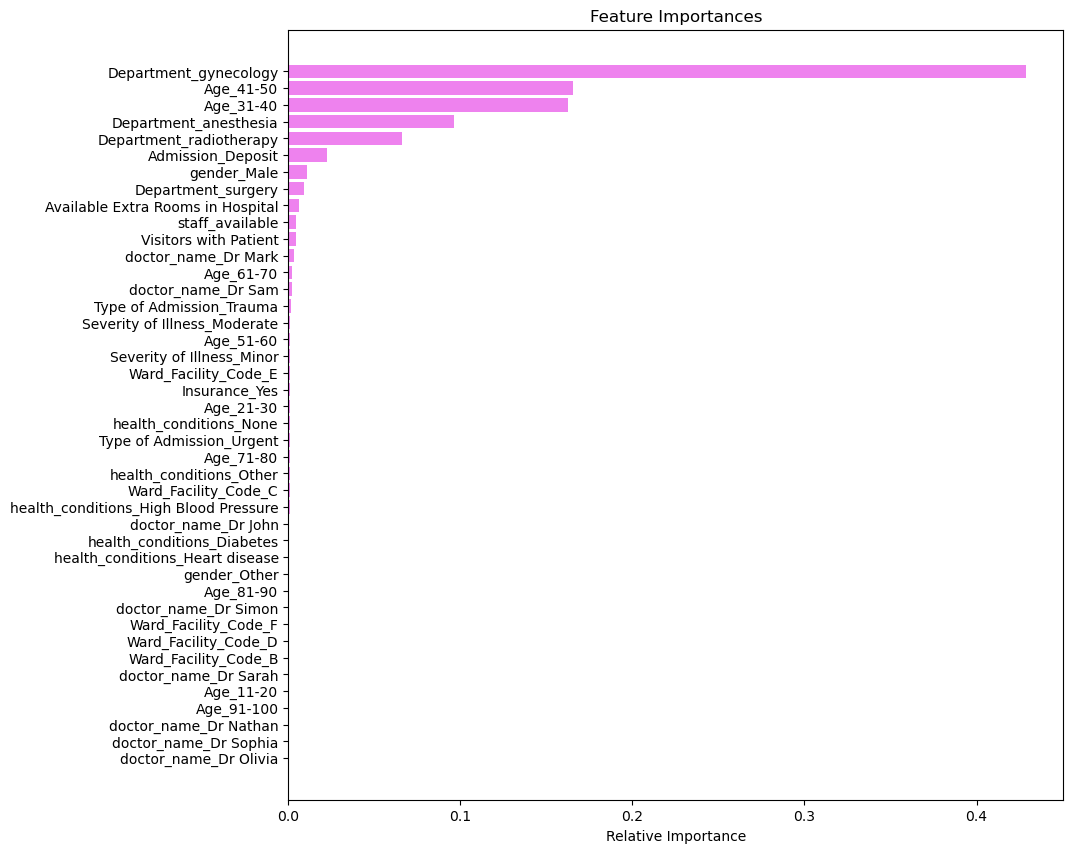

In [ ]:
features = list(x.columns)
importances = rf_tuned_regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Observations:**

- The most important features are Department_gynecology, Age_41_50, and Age_31_40, followed by Department_anesthesia, Department_radiotherapy, and Admission_Deposit.
- The rest of the variables have little or no influence on the length of stay in the hospital in this model.

## **Business Insights and Recommendations**

- Gynecology is the busiest department of the hospital and it handles 68.7% of the total number of patients. It needs ample resources and staff for the smooth functioning of the department.
- The maximum number of visitors can go up to 32 which is very high. A restriction can be imposed on this.
- 74.2% of the patients are female. Thus, resources need to be procured while keeping this figure in mind.
- A large percentage of patients (89.3%) are in trauma or emergency during admission. An increase in ambulances and emergency rooms can reduce the risk of casualties.
- Ward A has the most number of patients who stay for the longest and the most serious patients. These wards can be equipped with more resources and staff to reduce the length of stay of these patients.
- Elderly patients (51-100) and children (1-10) stay for the longest. Extra attention to these age groups can lead to a faster discharge from the hospital.
- Wards D, E, and C have the most visitors with a patient. These wards will need more space and amenities like washrooms, shops, and lobbies for the visitors. Spaces can also be rented out to shop owners and advertisements to generate extra income.
- Finally, the Random Forest Regressor can predict the length of stay of the patient with just an error of 1 day. The hospital can use these predictions to allocate the resources and staff accordingly and reduce any kind of wastage. The hospital can also allocate the wards and doctors accordingly to optimize admissions even during emergencies.